In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os
import pickle

import sys
from pathlib import Path

PROJECT_ROOT = str(Path.cwd().parent.resolve())
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import Class_site as site
import free_fermion_representation as f
import variables_phasediagram_simulation as vps

## Level spacing ratio

find level spacing ratio for different unitaries in the range between T =0.67 and T = 1, Delta = 0...0.5

In [6]:
def floquet_T_delta(model, fgs, T, delta, edgepar = None):

    _, _, _, R0 = fgs.floquet_operator_ham(T)
    _, _, _, Re = fgs.floquet_operator_ham(T, anyon=True)
    
    if delta != 0:
        V0 = f.generate_disorder_term(model, fgs.Cov, delta, edgepar = edgepar)
        Ve = f.generate_disorder_term(model, fgs.Cov, delta, type="Anyon", edgepar = edgepar)
        R_V0 = f.floquet_operator(V0, T, alpha = np.pi/4.)
        R_Ve = f.floquet_operator(Ve, T, alpha = np.pi/4.)
        R_V0_R0 = R_V0 @ R0
        R_Ve_Re = R_Ve @ Re
    else:
        R_V0_R0 = R0
        R_Ve_Re = Re

    return R_V0_R0, R_Ve_Re

In [7]:
def level_spacing_ratio(op, T):
    """
    Compute level-spacing ratio for eigenphases of unitary `op`.

    Returns:
      mean_r : float
        Average of r_n = min(s_n, s_{n+1})/max(s_n, s_{n+1}) over consecutive spacings.
      r_vals : ndarray
        Array of r_n values.
    Notes:
      - Uses principal angles via np.angle (in (-pi,pi]) and accounts for the circular wrap.
      - Converts phase spacings to "energies" by dividing by T.
    """
    
    ev = np.linalg.eigvals(op)
    #print(ev)
    if ev.size < 3:
        return np.nan, np.array([])

    angles = np.angle(ev)                       # principal values in (-pi, pi]
    #print(angles)
    angles_sorted = np.sort(angles)             # sort on the circle (linear order)
    #print(angles_sorted)
    spacings = np.diff(angles_sorted)           # interior spacings
    wrap_spacing = (angles_sorted[0] + 2*np.pi) - angles_sorted[-1]
    spacings = np.concatenate((spacings, [wrap_spacing]))  # include wrap-around
    #print(spacings)

    # spacings = spacings / T                     # convert to energy units if desired

    # compute r_n = min(s_n, s_{n+1})/max(s_n, s_{n+1})
    if spacings.size < 2:
        return np.nan, np.array([])
    s1 = spacings[:-1]
    s2 = spacings[1:]
    r_vals = np.minimum(s1, s2) / np.maximum(s1, s2)

    mean_r = np.mean(r_vals)
    return mean_r, r_vals

In [8]:
oper = np.array([[np.exp(1j * 0.1), 0, 0],
                 [0, np.exp(1j * 1.5), 0],
                 [0, 0, np.exp(1j * 2.8)]])

print(oper)

[[ 0.99500417+0.09983342j  0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.0707372 +0.99749499j  0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j         -0.94222234+0.33498815j]]


In [9]:
mean_r, r_vals = level_spacing_ratio(oper, T=1.0)
print()
print("Mean level-spacing ratio:", mean_r)
print("Level-spacing ratios:", r_vals)


Mean level-spacing ratio: 0.6456885568061953
Level-spacing ratios: [0.92857143 0.36280569]


In [10]:
def lsr_diagram_total(delta_list, T_list, model, fgs, N_disorder, save_dir=None):
    """
    Generate level-spacing ratio diagram over ranges of disorder strength and period.

    Parameters:
      delta_list : list or ndarray
        List of disorder strengths to sample.
      T_list : list or ndarray
        List of periods to sample.
      model : Class_site.Site
        The model defining the system.
      fgs : free_fermion_representation.FreeFermionRepresentation
        The free fermion representation of the system.
      N_disorder : int
        Number of disorder realizations to average over.
    """
    mean_matrix_0 = np.zeros((len(delta_list), len(T_list)))
    mean_matrix_e = np.zeros((len(delta_list), len(T_list)))
    values_matrix_0 = np.zeros((len(delta_list), len(T_list)), dtype=object)
    values_matrix_e = np.zeros((len(delta_list), len(T_list)), dtype=object)


    for i, delta in enumerate(tqdm(delta_list, desc="Deltas")):
        for j, T in enumerate(tqdm(T_list, desc=f"T for delta={delta}", leave=False)):
            mean_r_0_list = []
            mean_r_e_list = []
            r_values_0_list = []
            r_values_e_list = []

            for _ in range(N_disorder):
                R_V0_R0, R_Ve_Re = floquet_T_delta(model, fgs, T, delta)
                mean_r_0, r_values_0 = level_spacing_ratio(R_V0_R0, T)
                mean_r_e, r_values_e = level_spacing_ratio(R_Ve_Re, T)
                if not np.isnan(mean_r_0):
                    mean_r_0_list.append(mean_r_0)
                if not np.isnan(mean_r_e):
                    mean_r_e_list.append(mean_r_e)
                if r_values_0.shape[0] > 0:
                    r_values_0_list.append(r_values_0)
                if r_values_e.shape[0] > 0:
                    r_values_e_list.append(r_values_e)

            mean_matrix_0[i, j] = np.mean(mean_r_0_list) if mean_r_0_list else np.nan
            mean_matrix_e[i, j] = np.mean(mean_r_e_list) if mean_r_e_list else np.nan
            values_matrix_0[i, j] = r_values_0_list
            values_matrix_e[i, j] = r_values_e_list


    
    if save_dir is not None:
        general_dir = "lsr_matrices"
        full_dir = os.path.join(general_dir, save_dir)
        os.makedirs(full_dir, exist_ok=True)
        with open(os.path.join(full_dir, "mean_0.pkl"), "wb") as ffile:
            pickle.dump(mean_matrix_0, ffile)
        with open(os.path.join(full_dir, "mean_e.pkl"), "wb") as ffile:
            pickle.dump(mean_matrix_e, ffile)
        with open(os.path.join(full_dir, "values_0.pkl"), "wb") as ffile:
            pickle.dump(values_matrix_0, ffile)
        with open(os.path.join(full_dir, "values_e.pkl"), "wb") as ffile:
            pickle.dump(values_matrix_e, ffile)

    return mean_matrix_0, mean_matrix_e


In [11]:
delta_list = vps.delta_list_3
T_list = vps.T_list_2[::-1]

In [12]:
print(T_list)

[0.1, 0.13750000000000007, 0.17500000000000004, 0.21250000000000002, 0.25, 0.2875, 0.32500000000000007, 0.36250000000000004, 0.4, 0.4375, 0.475, 0.5125, 0.55, 0.5875, 0.625, 0.6625000000000001, 0.7, 0.7375, 0.775, 0.8125, 0.85, 0.8875, 0.925, 0.9625, 1.0]


In [13]:
model = site.SitesOBC(Npx = 21, Npy = 21, edge = True)
fgs = f.FermionicGaussianRepresentation(model)

In [14]:
lsr_matrix_0, lsr_matrix_e = lsr_diagram_total(delta_list, T_list, model, fgs, N_disorder=1, save_dir = "2.size21_delta3_T2_Ndisorder1")

Deltas:   0%|          | 0/11 [00:00<?, ?it/s]

T for delta=0:   0%|          | 0/25 [00:00<?, ?it/s]

/var/folders/6j/zg3nz4053f97fyqx4w2b6pxc0000gn/T/ipykernel_80843/253946865.py:36: RuntimeWarning: invalid value encountered in divide
  r_vals = np.minimum(s1, s2) / np.maximum(s1, s2)


T for delta=0.05:   0%|          | 0/25 [00:00<?, ?it/s]

T for delta=0.1:   0%|          | 0/25 [00:00<?, ?it/s]

T for delta=0.15:   0%|          | 0/25 [00:00<?, ?it/s]

T for delta=0.2:   0%|          | 0/25 [00:00<?, ?it/s]

T for delta=0.25:   0%|          | 0/25 [00:00<?, ?it/s]

T for delta=0.3:   0%|          | 0/25 [00:00<?, ?it/s]

T for delta=0.35:   0%|          | 0/25 [00:00<?, ?it/s]

T for delta=0.4:   0%|          | 0/25 [00:00<?, ?it/s]

T for delta=0.45:   0%|          | 0/25 [00:00<?, ?it/s]

T for delta=0.5:   0%|          | 0/25 [00:00<?, ?it/s]

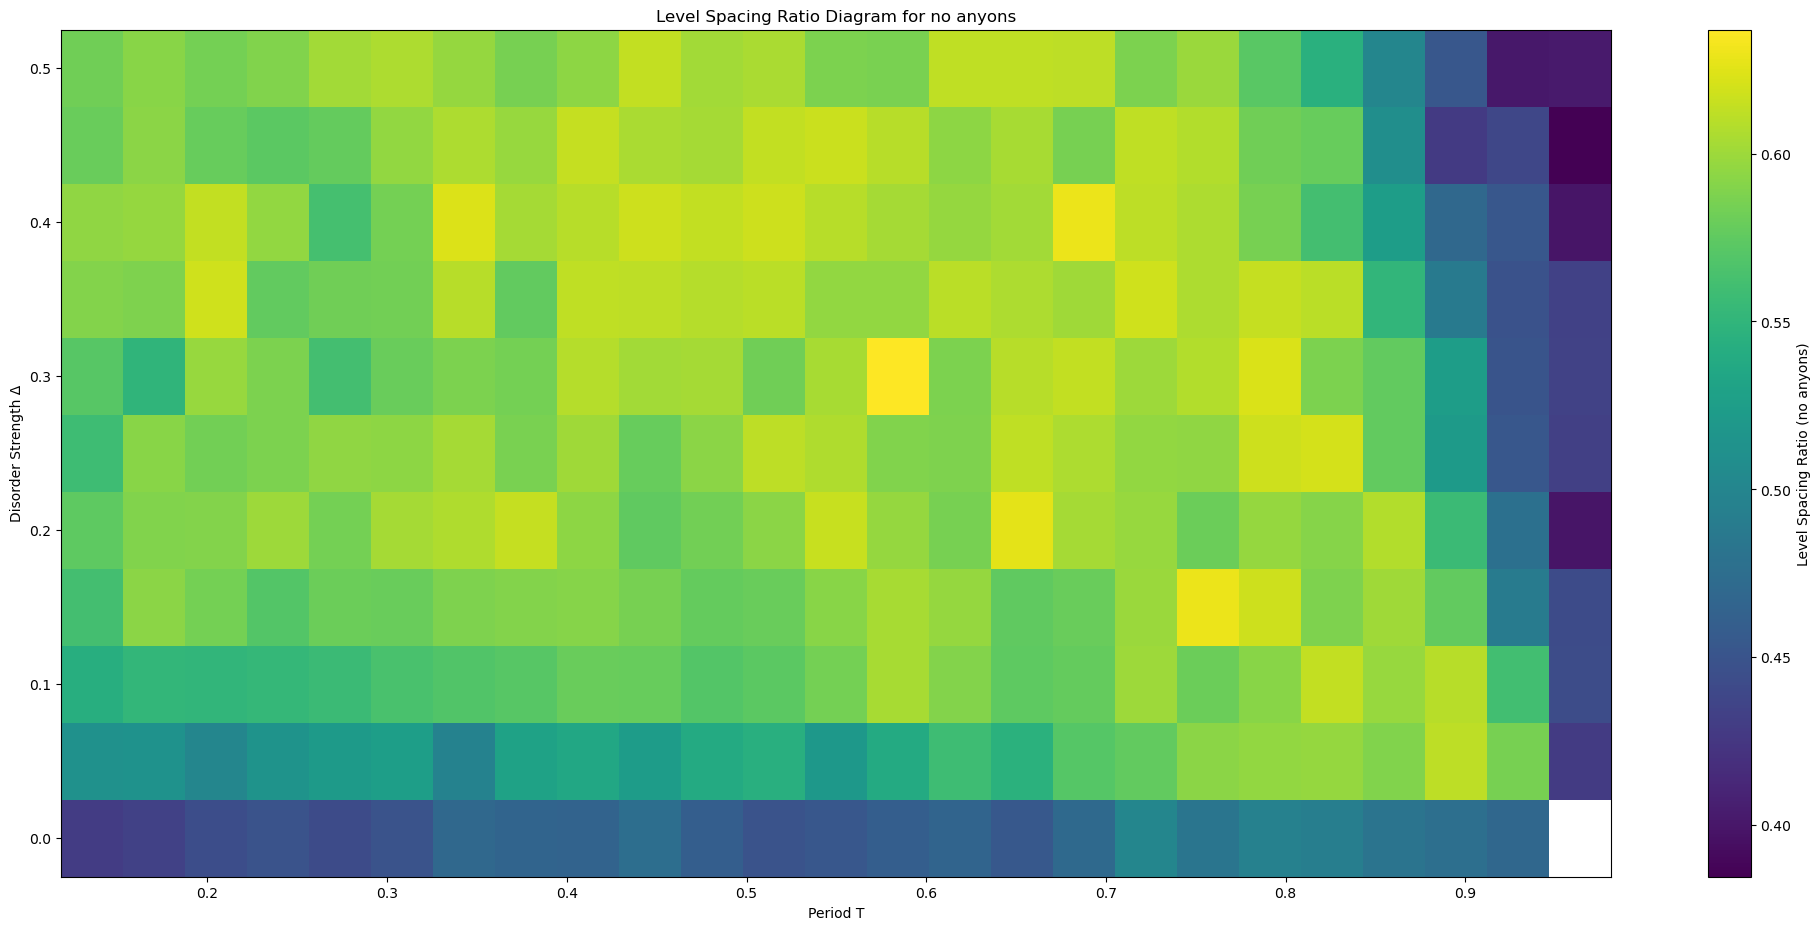

In [15]:
figsize = (len(T_list), len(delta_list))

deltaT = np.abs(T_list[1]-T_list[0])/2
deltadelta = (delta_list[1]-delta_list[0])/2

T_start = T_list[0]+deltaT
T_finish = T_list[-1]-deltaT    

plt.figure(figsize=figsize)
plt.imshow(lsr_matrix_0, 
           aspect='auto',
           origin='lower',   
           extent=[T_start, T_finish, delta_list[0]-deltadelta, delta_list[-1]+deltadelta],
           cmap='viridis')
plt.colorbar(label='Level Spacing Ratio (no anyons)')
plt.xlabel('Period T')
plt.ylabel('Disorder Strength Δ')
plt.title('Level Spacing Ratio Diagram for no anyons')
plt.savefig('2. size21_lsr_0_delta_list_3_T_list_2.png')

Text(0.5, 1.0, 'Level Spacing Ratio Diagram for e anyon')

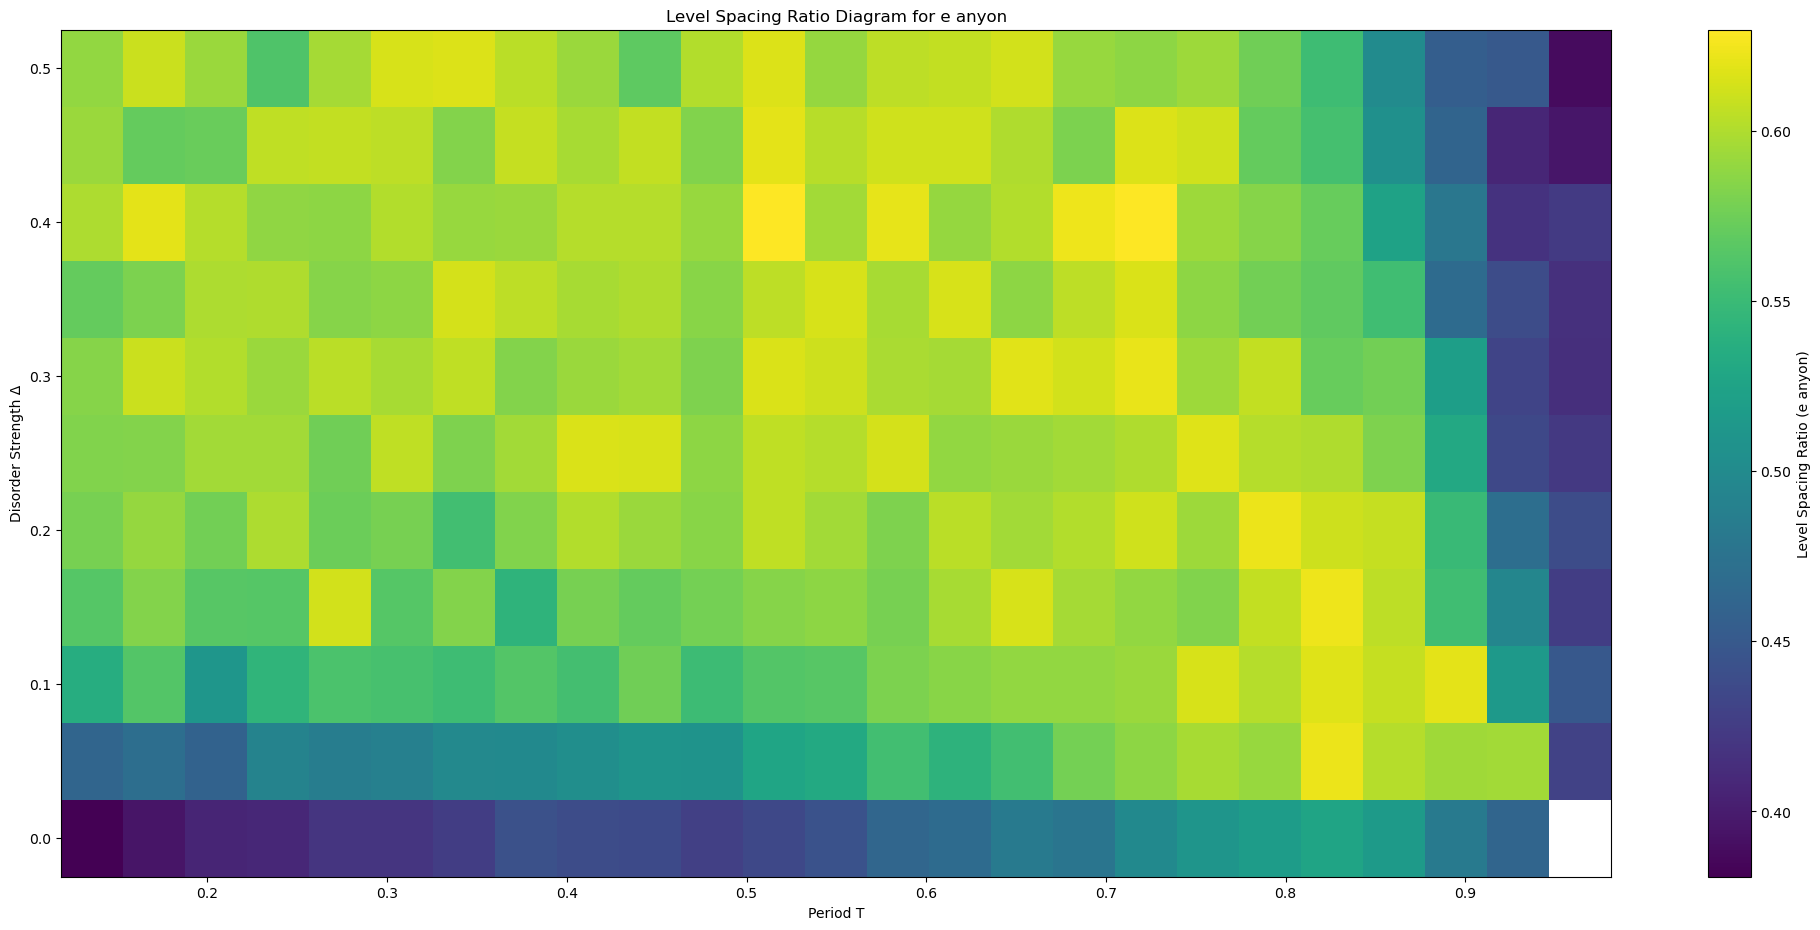

In [16]:
figsize = (len(T_list), len(delta_list))

deltaT = np.abs(T_list[1]-T_list[0])/2
deltadelta = (delta_list[1]-delta_list[0])/2

T_start = T_list[0]+deltaT
T_finish = T_list[-1]-deltaT    

plt.figure(figsize=figsize)
plt.imshow(lsr_matrix_e, 
           aspect='auto',
           origin='lower',   
           extent=[T_start, T_finish, delta_list[0]-deltadelta, delta_list[-1]+deltadelta],
           cmap='viridis')
plt.colorbar(label='Level Spacing Ratio (e anyon)')
plt.xlabel('Period T')
plt.ylabel('Disorder Strength Δ')
plt.title('Level Spacing Ratio Diagram for e anyon') 

### Calculate r_n distribution

In [23]:
# def _flatten_r_cell(cell):
#     """
#     Flatten a cell array of r values into a single 1D array.
#     """
#     flat_list = []
#     if isinstance(cell, np.ndarray):
#         cell = cell.tolist()
#     for sublist in cell:
#         for arr in sublist:
#             flat_list.extend(arr)
#     return np.array(flat_list)

def _flatten_r_cell(cell):
    """
    Normalize a cell from values_matrix to a 1D numpy array of floats.
    - cell may be: [] (empty list), [array1, array2, ...], a single ndarray, or list of floats.
    """
    if cell is None:
        return np.array([])
    # If cell is a numpy object array containing python lists/arrays, convert to list first
    if isinstance(cell, np.ndarray) and cell.dtype == object:
        cell = cell.tolist()
    if isinstance(cell, (list, tuple, np.ndarray)):
        out = []
        for el in cell:
            if el is None:
                continue
            # if element is array-like, extend; otherwise append scalar
            try:
                arr = np.asarray(el).ravel()
                # skip zero-length arrays
                if arr.size > 0:
                    out.extend(arr.tolist())
            except Exception:
                out.append(el)
        return np.asarray(out)
    # fallback: single scalar
    return np.asarray([cell])


In [84]:
def plot_lsr_histogram(values_matrix, delta_list, T_list, i, j, bins=50, density=True, range=(0,1.1), save_path=None, ax=None, title=None):
    """
    Plot histogram of r-values for grid cell (delta, T).
    - values_matrix: object array produced by lsr_diagram_total (each cell is a list of arrays or similar)
    - i, j: indices in the matrix
    - bins, density, range: forwarded to plt.hist
    - save_path: if provided, saves the figure (PNG)
    - returns matplotlib Axes
    """

    delta = delta_list[i]
    T = T_list[j]

    data = _flatten_r_cell(values_matrix[i, j])
    if data.size == 0:
        print(f"No r-values for cell ({i}, {j})")
        return None
    own_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(5,4))
        own_fig = True
    ax.hist(data, bins=bins, density=density, range=range, color='C0', alpha=0.75, histtype='bar', edgecolor='black', linewidth=1)
    ax.set_xlim(range)
    ax.set_xlabel('r')
    ax.set_ylabel('Probability density' if density else 'Counts')
    if title is None:
        title = rf'LSR histogram ($\Delta$={delta}, T={T:.3f}), n={data.size}'
    ax.set_title(title)
    ax.grid(alpha=0.2)
    if save_path:
        # if we created the figure, save it; otherwise create a figure wrapper and save
        if own_fig:
            fig.tight_layout()
            fig.savefig(save_path, dpi=150)
        else:
            # try to save via current figure
            plt.gcf().tight_layout()
            plt.gcf().savefig(save_path, dpi=150)
    return ax

In [ ]:
def multiplot_lsr_hist(values_matrix, delta_list, T_list, i_list, j_list, bins=50, density=True, range=(0,1), fig_name=None, title=None):
    """
    i_list: list of column indices (delta indices)
    j_list: list of row indices (T indices)
    """
    rows = len(j_list)
    cols = len(i_list)

    # squeeze=False keeps axs as 2D array even for single row/col
    fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(5*cols, 5*rows), squeeze=False)

    for col_idx, i in enumerate(i_list):
        for row_idx, j in enumerate(j_list):
            ax = axs[row_idx, col_idx]            # row, column
            plot_lsr_histogram(values_matrix, delta_list, T_list, i, j,
                               bins=bins, density=density, range=range,
                               save_path=None, ax=ax, title=None)

    # suptitle then adjust layout to reduce the reserved whitespace
    # if title:
    #     fig.suptitle(title)
    # else:
    #     fig.suptitle('LSR Histogram')

    # reduce the top margin reserved for suptitle (tune 0.95/0.92 as needed)
    # fig.tight_layout(rect=[0, 0, 1, 0.92])
    # alternativa: fig.subplots_adjust(top=0.92)
    fig.tight_layout()

    if fig_name:
        full_name = os.path.join('figures/lsr', fig_name)
        os.makedirs(os.path.dirname(full_name), exist_ok=True)
        plt.savefig(full_name, bbox_inches='tight')

    return fig, axs

In [140]:
full_dir = os.path.join("lsr_matrices", "2.size21_delta3_T2_Ndisorder1")
name = os.path.join(full_dir, "values_0")
with open(f'{name}.pkl', 'rb') as ffile:
    values_matrix_0 = pickle.load(ffile)

In [141]:
def save_all_lsr_histograms(values_matrix, delta_list, T_list, out_dir, prefix="lsr", bins=50, density=True, range=(0,1)):
    """
    Save histogram PNGs for all (i,j) entries that have data.
    Filenames use delta and T values for clarity.
    """
    os.makedirs(out_dir, exist_ok=True)
    for i, delta in enumerate(delta_list):
        for j, T in enumerate(T_list):
            data = _flatten_r_cell(values_matrix[i, j])
            if data.size == 0:
                continue
            safe_name = f"{prefix}_delta{delta:.4g}_T{T:.4g}_i{i}_j{j}.png"
            save_path = os.path.join(out_dir, safe_name)
            title = f"LSR histogram Δ={delta}, T={T} (n={data.size})"
            plot_lsr_histogram(values_matrix, i, j, bins=bins, density=density, range=range, save_path=save_path, title=title)
    print("Saved histograms to", out_dir)

<Axes: title={'center': 'LSR histogram ($\\Delta$=0, T=0.138), n=965'}, xlabel='r', ylabel='Counts'>

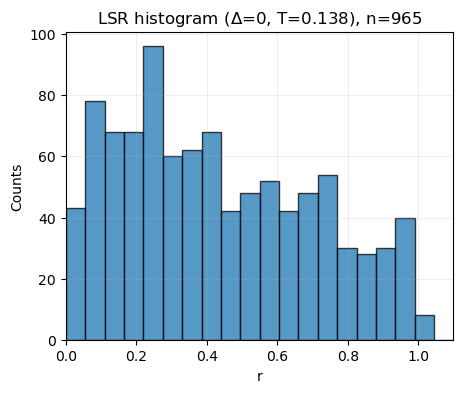

In [142]:
plot_lsr_histogram(values_matrix_0, delta_list = delta_list, T_list = T_list, i = 0, j= 1, bins=20, density = False)

(<Figure size 500x12500 with 25 Axes>,
 array([[<Axes: title={'center': 'LSR histogram ($\\Delta$=0, T=0.100), n=965'}, xlabel='r', ylabel='Counts'>],
        [<Axes: title={'center': 'LSR histogram ($\\Delta$=0, T=0.138), n=965'}, xlabel='r', ylabel='Counts'>],
        [<Axes: title={'center': 'LSR histogram ($\\Delta$=0, T=0.175), n=965'}, xlabel='r', ylabel='Counts'>],
        [<Axes: title={'center': 'LSR histogram ($\\Delta$=0, T=0.213), n=965'}, xlabel='r', ylabel='Counts'>],
        [<Axes: title={'center': 'LSR histogram ($\\Delta$=0, T=0.250), n=965'}, xlabel='r', ylabel='Counts'>],
        [<Axes: title={'center': 'LSR histogram ($\\Delta$=0, T=0.287), n=965'}, xlabel='r', ylabel='Counts'>],
        [<Axes: title={'center': 'LSR histogram ($\\Delta$=0, T=0.325), n=965'}, xlabel='r', ylabel='Counts'>],
        [<Axes: title={'center': 'LSR histogram ($\\Delta$=0, T=0.363), n=965'}, xlabel='r', ylabel='Counts'>],
        [<Axes: title={'center': 'LSR histogram ($\\Delta$=0, T=0

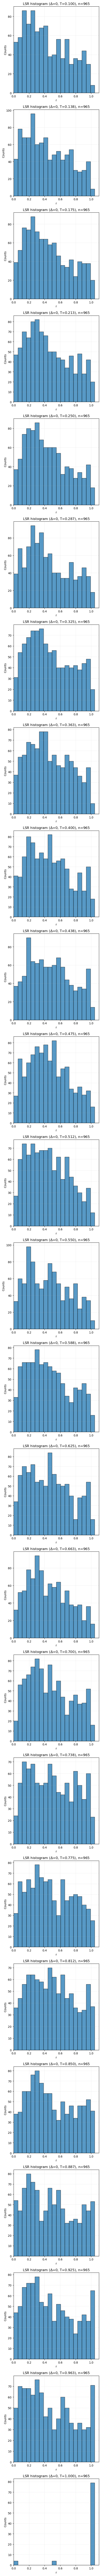

In [145]:
multiplot_lsr_hist(values_matrix_0, delta_list, T_list, [0], np.arange(len(T_list)).tolist(), bins = 20, density = False, fig_name = "multiplot_histogram")